# Stochastic gradient descent on beer reviews

I collaborated with Ruben Abbou.

In [69]:
import numpy as np
import json
import re
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import time
import random
from math import exp

In [70]:
with open('/project2/cmsc25025/beer_review/labeled.json', 'r') as f:
    brv = json.loads(f.read())

## Part 1: Data inspection.
To warm up, check the mean, median and standard deviation of the overall ratings for each beer and brewer. Do you think people have similar taste?

In [71]:
beers = set([br['beer_name'] for br in brv])
brewers = set([br['brewer'] for br in brv])

In [72]:
beer_values = {}
for b in beers:
    beer_values[b] = []
for b in brv:
    beer_values[b['beer_name']].append(b['overall'])
beer_statistics = {}
for k,v in beer_values.items():
    beer_statistics[k] = {'sd': np.std(v), 'median': np.median(v), 'mean':np.mean(v)}

In [73]:
brewer_values = {}
for b in brewers:
    brewer_values[b] = []
for b in brv:
    brewer_values[b['brewer']].append(b['overall'])
brewer_statistics = {}
for k,v in brewer_values.items():
    brewer_statistics[k] = {'sd': np.std(v), 'median': np.median(v), 'mean':np.mean(v)}

In [78]:
#For the sake of not printing too much stuff, I only print the first 100 items.
for k,v in list(beer_statistics.items())[:100]:
    print("Beer: " + str(k) +"\n" 
          + "mean: " + str(v['mean']) 
          + " median: " + str(v['median']) 
          + " sd: " + str(v['sd']))
print("\n")
for k,v in list(brewer_statistics.items())[:100]:
    print("Brewer: " + str(k) +"\n" 
          + "mean: " + str(v['mean']) 
          + " median: " + str(v['median']) 
          + " sd: " + str(v['sd']))

Beer: Schoune La Trip des Schoune
mean: 12.17910447761194 median: 13.0 sd: 2.849065692019515
Beer: Full Circle Euro-Fuggle
mean: 12.285714285714286 median: 11.0 sd: 3.1036515689143473
Beer: Blue Frog 10th Anniversary Ale
mean: 15.166666666666666 median: 16.0 sd: 2.266911751455907
Beer: Quay Street Blue Water Pale Ale
mean: 12.0 median: 11.5 sd: 1.632993161855452
Beer: Captain Lawrence Barrel Select Cherry
mean: 14.0 median: 14.5 sd: 1.632993161855452
Beer: Lost Abbey Gift of the Magi
mean: 15.01126126126126 median: 15.0 sd: 1.7313638935078186
Beer: John Harvards Brewers Gold
mean: 10.0 median: 10.0 sd: 0.0
Beer: Kelham Island Island
mean: 13.4 median: 13.0 sd: 0.48989794855663565
Beer: Hidden Fantasy
mean: 12.0625 median: 12.0 sd: 2.0757152381769517
Beer: Red Rock Czech Pilsner
mean: 9.5 median: 9.0 sd: 2.362907813126304
Beer: Bull Falls March Madness Ale
mean: 15.0 median: 15.0 sd: 0.0
Beer: Freisinger Schwarzbier
mean: 12.307692307692308 median: 12.0 sd: 1.6817854699288806
Beer: Bryg

It seems like people have different tastes, but there are definitely beers and brewer that are generally more liked. This is apparrent because the standard deviations are not too high, but the beers and brewers with a significant amount of reviews do have a decent standard deviation. which shows that there is definitely some differentiation in taste. There is also an extreme range of means, which shows that there is some form of objective ranking.

## Part 2: Sentiment analysis.

In [79]:
with open('/project/cmsc25025/beer_review/vocab_30.json', 'r') as f:
         vocab = json.load(f)
vocab_set = set(vocab)

In [80]:
ratings = [1 if b['overall'] >=14 else 0 for b in brv]

demo_brv = brv[:10000]
demo_ratings = ratings[:10000]


### (a) Generating features.
You need to represent text reviews in terms of a vector of features (covariates). One simple but effective representation is to use membership in a fixed vocab- ulary. Suppose the vocabulary contains p words. For a given review, you normalize the text, and separate it into space-delimited tokens. For each of the tokens, if it is in the dictionary you have a one for the corresponding word in the feature vector, and you ignore it otherwise.

In [110]:
def makeCSRandLabels(words, ratings):
    vocab_words = [list(vocab_set & set(re.sub("[^\w]", " ",  br['review'].lower()).split())) for br in words]
    vocab_words_ratings = [(x, ratings[i]) for i,x in enumerate(vocab_words) if x != []]
    vocab_words = [x for x,i in vocab_words_ratings]
    csr_ratings = [i for x,i in vocab_words_ratings]
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for v in vocab:
        index = vocabulary.setdefault(v, len(vocabulary))
    for d in vocab_words:
        for term in d:
            index = vocabulary.setdefault(term, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr)), csr_ratings

In [111]:
csr_vocab, csr_labels = makeCSRandLabels(demo_brv, demo_ratings)

### (b) Logistic regression using Newton’s method
Logistic regression using Newton’s method. Train an l2-regularized logistic regression
classifier using the sklearn.linear model.LogisticRegression class. To select the regularization parameter C = 1/λ, you should try different values on the validation
set. Pick the best. How long does it take to train?

In [112]:
def getDualDataRange(data, ratings,l,r):
    return csr_matrix(data[int(l*len(data)):int(r*len(data))]), ratings[int(l*len(ratings)):int(r*len(ratings))]

train_csr_words, train_ratings = getDualDataRange(csr_vocab.toarray(), csr_labels, 0, 0.7)
valid_csr_words, valid_ratings = getDualDataRange(csr_vocab.toarray(), csr_labels, 0.7, 0.85)
test_csr_words, test_ratings = getDualDataRange(csr_vocab.toarray(), csr_labels, 0.85, 1)


In [109]:
# Testing for best lambda

ltrain_csr_words, ltrain_ratings = getDualDataRange(csr_vocab.toarray(), csr_labels, 0, 0.07)
lvalid_csr_words, lvalid_ratings = getDualDataRange(csr_vocab.toarray(), csr_labels, 0.07, 0.085)

ls = [5,10,20,30,40,50,75,100,200,300,400,500]
errors = []
for l in ls:
    lg=LogisticRegression(fit_intercept=True, C=l, penalty='l2',
                multi_class='multinomial',solver='newton-cg')
    model = lg.fit(ltrain_csr_words, ltrain_ratings)
    predicted_valid_ratings = lg.predict(lvalid_csr_words)
    error = np.mean(lvalid_ratings != predicted_valid_ratings)
    errors.append(error)

In [85]:
for i in range(len(ls)):
    print("The error rate for 1/lambda = " + str(ls[i]) + " is " + str(errors[i]))
error_pairs = [(ls[i], errors[i]) for i in range(len(ls))]
min_pair = min(error_pairs, key = lambda x: x[1])
print("The minimum 1/lambda value is: " + str(min_pair[0]))
l = min_pair[0]

The error rate for 1/lambda = 5 is 0.36
The error rate for 1/lambda = 10 is 0.36
The error rate for 1/lambda = 20 is 0.35333333333333333
The error rate for 1/lambda = 30 is 0.36
The error rate for 1/lambda = 40 is 0.36
The error rate for 1/lambda = 50 is 0.36
The error rate for 1/lambda = 75 is 0.36666666666666664
The error rate for 1/lambda = 100 is 0.36666666666666664
The error rate for 1/lambda = 200 is 0.36
The error rate for 1/lambda = 300 is 0.36666666666666664
The error rate for 1/lambda = 400 is 0.36666666666666664
The error rate for 1/lambda = 500 is 0.36666666666666664
The minimum 1/lambda value is: 20


In [86]:
#Fitting the Regression
start_time = time.time()
lg=LogisticRegression(fit_intercept=True, C=l, penalty='l2',
                multi_class='multinomial',solver='newton-cg')
model = lg.fit(train_csr_words, train_ratings)
end_time = time.time()
print("Traning the model took %s seconds." % (end_time - start_time))

Traning the model took 11.313294887542725 seconds.


In [87]:
# Testing the Training
predicted_test_ratings = lg.predict(test_csr_words)
error = np.mean(test_ratings != predicted_test_ratings)
print("The error rate is:", error)

The error rate is: 0.19786096256684493


Do the same thing using the LinearSVC class in sklearn.svm. Use loss=’hinge’. Compare the results of the logistic loss to the hinge loss. Is there a difference?

In [88]:
ltrain_csr_words, ltrain_ratings = getDualDataRange(csr_vocab.toarray(), csr_labels, 0, 0.07)
lvalid_csr_words, lvalid_ratings = getDualDataRange(csr_vocab.toarray(), csr_labels, 0.07, 0.085)

ls = [5,10,20,30,40,50,75,100,200,300,400,500]
errors = []
for l in ls:
    hinge=LinearSVC(loss='hinge', penalty='l2',dual=True, tol=.001, C = l, max_iter = 100000)
    model = hinge.fit(ltrain_csr_words, ltrain_ratings)
    predicted_valid_ratings = hinge.predict(lvalid_csr_words)
    error = np.mean(lvalid_ratings != predicted_valid_ratings)
    errors.append(error)

In [89]:
error_pairs = [(ls[i], errors[i]) for i in range(len(ls))]
min_pair = min(error_pairs, key = lambda x: x[1])
lhinge = min_pair[0]

In [113]:
#Fitting the Regression

start_time = time.time()
hinge=LinearSVC(loss='hinge', penalty='l2',dual=True, tol=.001, C = l, max_iter = 100000)
model = hinge.fit(train_csr_words, train_ratings)
end_time = time.time()
print("Traning the model took %s seconds." % (end_time - start_time))

Traning the model took 8.50538682937622 seconds.


In [91]:
# Testing the Training
predicted_test_ratings = hinge.predict(test_csr_words)
error = np.mean(test_ratings != predicted_test_ratings)
print("The error rate is:", error)

The error rate is: 0.2520053475935829


The hinge model was extremely faster, but does get a slightly higher error rate. This is important to realize as using hinge is probably better when in an instance where you are willing to sacrifice accuracy for a faster runtime. For instance, if your dataset is extremely large and you are only testing whether the model is good and thus can sacrifice some accuracay.

### (c) Stochastic gradient descent
 Your next job is to train an l2-regularized logistic regression
classifier using stochastic gradient descent. Recall the SGD framework that was covered in
class using minibatches.

#### i. Initialize the model with θ = 0 (uniform).

#### ii. Randomly split the training data into mini-batches. Make one pass of the data, processing one mini-batch in every iteration. This is called one training epoch.

In [92]:
def getYhat(x, theta):
    return 1/(1+exp(-theta.dot(x)))

def getNewThetas(x, y, yhat, thetas, alpha, lamb):
    return thetas + alpha*((y - yhat) * yhat *(1 - yhat) * x - 2*lamb*thetas)

def getBatch(b, x, y):
    indices = random.sample(range(len(y)), b)
    xb = [x.getrow(i).toarray()[0] for i in indices]
    yb = [y[i] for i in indices]
    return xb,yb

def SGDstep(x,y, theta, alpha, lamb, b):
    xb, yb = getBatch(b, x, y)
    for i in range(b):
        yhat = getYhat(xb[i],theta)
        theta = getNewThetas(xb[i], yb[i], yhat, theta, alpha, lamb)
    return theta

def predictSGD(X,theta):
    yhats = []
    for i in range(X.shape[0]):
        x = X.getrow(i).toarray()[0]
        yhats.append(getYhat(x, theta))
    return yhats  
    

def runSGDsteps(x, y, theta, alpha, lamb, b, n):
    thetas = []
    for i in range(n):
        theta = SGDstep(x, y, theta, alpha, lamb, b)
        thetas.append(theta)
    
    return theta, thetas

In [93]:
theta = SGDstep(train_csr_words, train_ratings, np.zeros(len(vocab)), 0.001, 1/l, 10)
yhats = predictSGD(test_csr_words, theta)
predicted_test_ratings = [1 if yhat >= 0.5 else 0 for yhat in yhats]
wrong = 0
for i in range(len(test_ratings)):
    if test_ratings[i] != predicted_test_ratings[i]:
        wrong += 1
error = wrong/len(test_ratings)
print("The error rate is:", error)

The error rate is: 0.15641711229946523


#### iii. Repeat the last step a few times.

In [94]:
start_time = time.time()
theta, thetas = runSGDsteps(train_csr_words, train_ratings, np.zeros(len(vocab)), 0.001, 1/l, 100, 10)
end_time = time.time()
print("Traning the model took %s seconds." % (end_time - start_time))

Traning the model took 2.682340621948242 seconds.


In [95]:
def log_likelihood(x, y, theta):
    scores = np.dot(x, theta)
    ll = np.sum( y*scores - np.log(1 + np.exp(y)) )
    return ll

errors = []
ll = []
for theta in thetas:
    yhats = predictSGD(test_csr_words, theta)
    predicted_test_ratings = [1 if yhat >= 0.5 else 0 for yhat in yhats]
    wrong = 0
    for i in range(len(test_ratings)):
        if test_ratings[i] != predicted_test_ratings[i]:
            wrong += 1
    errors.append(wrong/len(test_ratings))
    #Note that computing the log likelihood kills the kernal and uses a lot of memory, so I commented it out. If you want to try to compute it, uncomment this.
    # ll.append(log_likelihood(test_csr_words,test_ratings,theta))


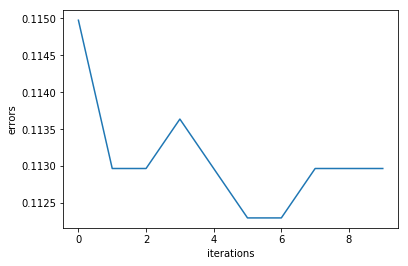

In [96]:
plt.plot(errors)
plt.ylabel('errors')
plt.xlabel('iterations')
plt.show()
if (len(ll)>0):
    plt.plot(ll)
    plt.ylabel('log-likelihood')
    plt.xlabel('iterations')
    plt.show()

In [97]:
error = min(errors)
print("The best error rate is:", error)

The best error rate is: 0.11229946524064172


As you can see, the error rate generally shrinks at first, but once it reaches a minimum, it begins to increase. This the behavior that we expect with SGD. As it is stochastic, we cannot expect the same behavior for every run and in some cases, the error rate may even increase.It appears that the best results happen around 3-5 iteraitons. Overall, the change in error rate is extremely small after the first iteration and thus if we run too many or too little iterations, it is not too big of a deal.

The error rate for SGD was significantly better than the error rate for the logistic and hinge regression. It runs slower than the hinge regression, but still runs fairly fast. This is definitely the best prediction function as it runs fast enough and has the best error rate.

## Part 3: Scores versus text.

In addition to text reviews, the users also scored appearance, aroma, palate, style, taste of
a beer. In this problem, you will check whether those scores could reflect people’s opinion
better than text.
Train another logistic regression model using those features. You should use the same SGD
algorithm as before. Compare the model using score features with that using review text.
Again, use the validation set to tune the regularization parameters, and retrain the model on
the union of training and validation set. Finally, compute the prediction error on the testing
set

In [98]:
scores = [[b["appearance"], b["aroma"], b["palate"], b["style"], b["taste"]] for b in brv]

In [99]:
demo_scores = scores[:10000]
demo_ratings = ratings[:10000]

def getDataRange(data, l, r):
    return data[int(l*len(data)):int(r*len(data))]
    

train_scores = getDataRange(demo_scores, 0, 0.7)
valid_scores = getDataRange(demo_scores, 0.7, 0.85)
test_scores = getDataRange(demo_scores, 0.85, 1)

train_ratings = getDataRange(demo_ratings, 0, 0.7)
valid_ratings = getDataRange(demo_ratings, 0.7, 0.85)
test_ratings = getDataRange(demo_ratings, 0.85, 1)

In [100]:
# Testing for best lambda

ltrain_scores = getDataRange(demo_scores, 0, 0.7)
lvalid_scores = getDataRange(demo_scores, 0.7, 0.85)
ltrain_ratings = getDataRange(demo_ratings, 0, 0.7)
lvalid_ratings = getDataRange(demo_ratings, 0.7, 0.85)

ls = [5, 10, 20, 30, 40, 50, 75, 100, 200, 300, 400,500, 1000, 2000, 5000, 10000]
errors = []
for l in ls:
    lg=LogisticRegression(fit_intercept=True, C=l, penalty='l2',
                multi_class='multinomial',solver='newton-cg')
    model = lg.fit(ltrain_scores, ltrain_ratings)
    predicted_valid_ratings = lg.predict(lvalid_scores)
    error = np.mean(lvalid_ratings != predicted_valid_ratings)
    errors.append(error)

In [101]:
error_pairs = [(ls[i], errors[i]) for i in range(len(ls))]
min_pair = min(error_pairs, key = lambda x: x[1])
l = min_pair[0]

In [102]:
#Fitting the Regression
start_time = time.time()
lg=LogisticRegression(fit_intercept=True, C=l, penalty='l2',
                multi_class='multinomial',solver='newton-cg')
model = lg.fit(train_scores, train_ratings)
end_time = time.time()
print("Traning the model took %s seconds." % (end_time - start_time))

Traning the model took 0.2636234760284424 seconds.


In [103]:
# Testing the Training
predicted_test_ratings = lg.predict(test_scores)
error = np.mean(test_ratings != predicted_test_ratings)
print("The error rate is:", error)

The error rate is: 0.09


In [104]:
#Running the SGD
def getScoreBatch(b, x, y):
    indices = random.sample(range(len(y)), b)
    xb = [x[i] for i in indices]
    yb = [y[i] for i in indices]
    return np.array(xb),np.array(yb)

def SGDScoreStep(x,y, theta, alpha, lamb, b):
    xb, yb = getScoreBatch(b, x, y)
    for i in range(b):
        yhat = getYhat(xb[i],theta)
        theta = getNewThetas(xb[i], yb[i], yhat, theta, alpha, lamb)
    return theta

def runSGDScoreSteps(x, y, theta, alpha, lamb, b, n):
    for i in range(n):
        theta = SGDScoreStep(x, y, theta, alpha, lamb, b)
    return theta

start_time = time.time()
theta = runSGDScoreSteps(train_scores, train_ratings, np.zeros(len(test_scores[0])), 0.001, 1/l, 100, 5)
end_time = time.time()
print("Traning the model took %s seconds." % (end_time - start_time))

Traning the model took 0.008984565734863281 seconds.


In [105]:
def predictScoresSGD(X,theta):
    yhats = []
    for i in range(len(X)):
        x = X[i]
        yhats.append(getYhat(x, theta))
    return yhats

yhats = predictScoresSGD(test_scores, theta)

predicted_test_ratings = [1 if yhat >= 0.5 else 0 for yhat in yhats]

In [106]:
wrong = 0
for i in range(len(test_ratings)):
    if test_ratings[i] != predicted_test_ratings[i]:
        wrong += 1
error = wrong/len(test_ratings)
print("The error rate is:", error)

The error rate is: 0.11133333333333334


Which model predicts better? Is the representation you constructed for text more powerful,
or are the scores? Why? Comment on your findings and discuss your thinking.

The scores model predicts way better than the test model in every case, but SGD. This makes sense as sentiment analysis is an extremely conplex field and thus our model does not do a fantastic job of performing it. In addition, there is a much more objective relationship between the scores and the ratings. The text in the review is informative, but it is far less deterministic of the actual rating. 

In the case of SGD, they interestingly get about the same error rate. This is a significant note as it shows that the power of the scores and text are about the same in determining the actual rating. I was really suprised to see this as I imagined that it would be better for the scores. However, with the scores, there are far more dimensions and thus it makes sense that SGD would perform well on the text.